Part 2 of **time series forecasting with energy**

In this section, I will investigate the problem at hand, formalising it, outlining methods for interpreting error, and setup a baseline using standard statistical methods for time-series analysis. The library `statsmodels` will come in handy for this task.

In [3]:
# LOAD THE REPOSITORY
# if you are working from outside the repository
# this happens if you use colab like I do
!git clone https://github.com/sandeshbhatjr/energy-prediction.git
!pip install -U --quiet pandas statsmodels tables numpy

fatal: destination path 'energy-prediction' already exists and is not an empty directory.


In [0]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

df = pd.read_hdf('energy-prediction/data/clean_german_df', key='df_with_load_and_gen')

If the `pd.read_hdf` throws an error, then it's probably because the version of `pyTables`, or `numpy`, or their combination that you are using is the wrong one. This is a known bug, updating should fix it: see https://stackoverflow.com/questions/54210073/pd-read-hdf-throws-cannot-set-writable-flag-to-true-of-this-array for details.

# Predictive models

The purpose is to explore SOTA models for time-series forecasting, specifically in terms of their applicability to forecasting *day-ahead prices*. This will involve both traditional statistical methods, as well as ML methods such as gradient boosting and deep recurrent NNs. In this notebook, I will restrict myself to exploring the traditional techniques, leaving NN based algorithms, and tree-based ones for later notebooks. That said, the general scheme of the problem that we set up here will serve as a basis for the rest of the analysis.  
The heuristics of the problem we approach is as follows: we have access to a history of recorded day-ahead prices (2015 to present day, to be more precise) and we are interested in forecasting the day-ahead prices for (at least) the following day. Additionally, we have access to the consumption and load forecast that is released before the day ahead price is set. Depending on the forecast window that you are aiming for, it is possible to use this as an exogenous series, so models accounting for both datasets should be considered.  
**Problem formulation**:  
Let $\{t^{\alpha_1}_1, t^{\alpha_2}_2 ..\} \in \mathfrak{T} \times \mathfrak{D}$ represent a time-ordered sequence with timestep of an hour; here the indexing is as follows: for $t^{\alpha_j}_i$, $i$ represents date, while $j \in \mathbb{R}^{24}$ represents the hour of the day. We are given some historic day-ahead prices $p^{\alpha_1}_{t_1}, p^{\alpha_2}_{t_1}, ... ,p_{t_k}^{\alpha_{24}}$, and in addition, we have a collection of exogenous time series- $d^{\alpha}_{t_1},d^{\alpha}_{t_2}, ..., d^{\alpha}_{t_k}$ indexed by $\alpha$, which includes the generation and consumption forecasts. Finally for each $t\in {t_1, ..., t_{k+h'}}, h'>> h$, we have some associated features $f^{\beta}_t$, where the features are known well into future (for example, if the day is a holiday or not).
The problem can be formulated in one of two ways.  
1. **The univariate approach:** 
2. **The multivariate approach:** You can consider the series as a multivariate one with a timestep of one day. forecast the future day-ahead prices $p_{t_{k+1}}, ..., p_{t_{k+h}}$ in a certain future window-size of $h \in \mathbb{N}$. 

As for the multivariate strategy, the following function does the necessary manipulation to our dataset.

In [5]:
def convert_to_multivariate_series(df, data_columns, daily_columns=['Daylight Savings Time']): 
  multi_df = df[data_columns].groupby(by=[df.index.date, df.index.time]).mean().unstack(-1)
  multi_df[daily_columns] = df[daily_columns]
  return multi_df

convert_to_multivariate_series(df, 
  ['Day Ahead Price', 
   'Wind onshore Generation',
   'Wind offshore Generation',
   'Photovoltaics Generation',
   'Total Load'],
   daily_columns=['Daylight Savings Time', 'Bidding Zone', 'Holidays']
).sample(5)

Day Ahead Price           ... Bidding Zone Holidays
                  00:00:00 01:00:00  ...                      
2016-09-18           22.39    21.22  ...     DE-AT-LU     None
2015-02-23           18.62    16.53  ...     DE-AT-LU     None
2017-12-01           35.82    38.59  ...     DE-AT-LU     None
2018-02-06           36.12    35.00  ...     DE-AT-LU     None
2020-01-17           27.36    27.16  ...        DE-LU     None

[5 rows x 123 columns]

In [0]:
def convert_to_univariate_series(multi_df, multi_column):
  uni_df = multi_df[multi_column].stack(-1)
  combined_index = uni_df.index.map(lambda x: dt.datetime.combine(x[0], x[1]))
  return uni_df.set_index(combined_index)

In [0]:
multi_df = convert_to_multivariate_series(
    df, 
    ['Day Ahead Price', 
     'Wind onshore Generation', 
     'Wind offshore Generation', 
     'Photovoltaics Generation', 
     'Total Load'], 
    daily_columns=['Daylight Savings Time', 'Holidays', 'Bidding Zone']
  )

**Windowed dataset using Keras Timeseries generator**

Most models will work not on the entire time series, but on a windowed subset of the time series. Keras has an inbuilt windowed dataset generator, but it helps to know a few things before we use that. It is primarily meant for use with Keras, so it produces a generator that outputs the dataset in batches as a list $[b_1, b_2, ...]$. Each batch $b_i$ consists of $[X,y]$, with each being a numpy array. The format here is as follows: each $X$ is a windowed dataset with following indices: `(sample, timestep, feature)`, while $y$ is of the form `(sample, value)`. The assumption here is that `y` consists of a single timestep, which works fine in our case.

In [0]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def get_windowed_dataset(df, X_cols, y_cols, window_size, return_generator=False, **kwargs):
  # use batch size if defined, else return the whole dataset in one batch
  try:
    batch_size = kwargs['batch_size']
  except KeyError as e:
    batch_size = len(df.index)
  X_data = df[X_cols].to_numpy()
  y_data = df[y_cols].to_numpy()
  generator = TimeseriesGenerator(
      X_data,
      y_data,
      length = window_size, 
      sampling_rate = 1,
      batch_size = batch_size)
  if return_generator:
    return generator
  else:
    X_batches = [X for (X, y) in generator]
    y_batches = [y for (X, y) in generator]
    return X_batches, y_batches

Just a quick check to see if the generator works as expected:

In [33]:
generator = get_windowed_dataset(
    df, 
    ['Day Ahead Price', 'Wind onshore Generation', 'Wind offshore Generation'], 
    ['Day Ahead Price'], 
    1, 
    return_generator = True,
    with_index = True
)

generator[0][0].shape, generator[0][1].shape

((44567, 1, 3), (44567, 1))

Check again for the $(X, y)$ windowed dataset generation.

In [10]:
X, y = get_windowed_dataset(
    df, 
    ['Day Ahead Price', 'Wind offshore Generation'], 
    ['Day Ahead Price'], 
    1
)

X[0].shape, y[0].shape

((44567, 1, 2), (44567, 1))

Everything looks in order.

Before proceeding to investigate our models, it is important to figure out a cross-validation strategy and testing strategy using a metric to assess the performance of each of our models. There are two points to keep in mind.  

1. The cross-validation strategy for temporal data is a bit different from randomly choosing a subset of the dataset. Since the goal of our analysis is to forecast future values using present data, we will likewise train on a dataset from the past, and validate it against a subset to the future of it. This simulates the actual situation at hand. The textbook technique on this even places a buffer between the training and test set, but since we do not have a lot of data, I will not do this; see [SE11, TAS00] for further details.
2. For a simple criterion to do a quick comparison of algorithms as a first step in model evaluation, the sMAPE suffices:
$$s = \frac{|y-\hat{y}|}{2(|y| + |\hat{y}|)} $$ This should be sufficient for a first-order estimate of how well our models are doing; later on, we can perform more sophisticated forms of tests for our analysis.

To cover pt. 1, we create a function to split the dataset into a train and test sets chronologically separated as described. We also create a GridsearchCV equivalent for time series for hyperparameter search in ML models.

In [0]:
def test_train_timesplit(df, train_size=0.9, test_size=0.1):
  """
    Returns test-train split data based on date with test chronologically later than train data.
  """
  min_date = df.index.min()
  max_date = df.index.max()
  train_split_date = min_date + (train_size*(max_date - min_date))
  test_split_date = train_split_date + (test_size*(max_date - min_date))
  train_df = df[df.index < train_split_date]
  test_df = df[(df.index > train_split_date) & (df.index < test_split_date)]
  return train_df, test_df

def day_forward_chaining(df, date_col_name='Date', k=10):
  for i in range(1,k):
    yield test_train_timesplit(df, train_size=(i/k), test_size=(1/k))

# The above function is the time-series equivalent of gridsearch CV
# Example use-case:
# for train_df, test_df in day_forward_chaining(german_df):
#   <<< do your model training and tuning here >>>

For the second part, to compute sMAPE for model evaluation, the following class is defined. This will isolate all the error analysis tools in one class that we can use across models.

In [0]:
class error_analysis:
  def __init__(self, y, yhat, verbose=False):
    # prediction_df needs to be a dataframe of predictions in column yhat with a datetime index
    # original_df needs to be a dataframe of actual values in column y with a datetime index
    if verbose:
      print(dates_considered)
    dates_considered = set(y.index.to_list()).intersection(set(yhat.index.to_list()))
    self.y = y.loc[dates_considered]
    self.yhat = yhat.loc[dates_considered]
  def residuals(self):
    residual_series = np.absolute(self.y - self.yhat)
    smape_series = (2*residual_series)/(self.yhat + self.y)
    return residual_series, smape_series
  def smape_by_hour(self):
    _, smape_series = self.residuals()
    smape_series.replace(np.inf, 0) # remove infinite values
    smape_df = smape_series.groupby([smape_series.index.date, smape_series.index.time]).mean().unstack(-1)
    return smape_df.mean(axis=0, skipna=True)*100
  def total_smape(self):
    smape_by_hour = self.smape_by_hour()
    return smape_by_hour.mean(skipna=True)

**Naive model and the baseline**

A naive model is as follows: $p_{t+h} = p_t $ for all $h$ in the future window. This allows us to setup a baseline which any meaningful model should be able to outperform, hence is useful in debugging complex models (especially deep ones, later on).

In [35]:
def naive_model(df, y_column):
  shifted_index = df.index + pd.Timedelta(1, unit='D')
  yhat = df.set_index(shifted_index)[y_column]
  return yhat

_, test_df = test_train_timesplit(df)
yhat = naive_model(test_df, 'Day Ahead Price')
y = test_df['Day Ahead Price']

naive_error = error_analysis(yhat, y)
naive_error.total_smape()

29.620433589742245

So, there's our baseline. Anything that performs worse usually means that we are doing something wrong.  

Another simple baseline is to simply take the weighted average of the previous values.

In [0]:
def mamodel(X, alpha=0.1):
  window_size = X.shape[1]
  weight = np.array([pow(alpha, i) for i in reversed(range(window_size))])
  return np.tensordot(weight, X, axes=(0,1)) / np.sum(weight)

# Regression and autoregressive models

For time-series data, regression usually presents itself in the form of auto-regression, i.e. regression in terms of previous time-step variable. A very simple example would be the $AR(k)$ models, where the hypothesis is as follows:
$$p_{t+h}=\sum_{i=0}^k\alpha_ip_{t-i}+\epsilon$$ where $\epsilon$ is random white noise.

The above technique is a very simple one; there are far more sophistical statistical techniques available. We will pursue them here through the use of `statsmodels` library. I will not explore the algorithms themselves in detail (though it will make for a good series of blog posts sometime in the near future; for now refer to [HA18] for details).

## On detrending/deseasonalising the dataset

In [0]:
from statsmodels.tsa.seasonal import STL

stl = STL(multi_df_at_0, period=2, seasonal=21)

## Univariate AR(k) with time trend

A simple way to approach the problem is to consider each hourly day-ahead price as a separate time-series. This lets us use the AR(k) and ARMA(p,q) models on them directly.

In [0]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

train_df, test_df = test_train_timesplit(df)
AR_model = AutoReg(train_df['Day Ahead Price'], 180, seasonal=True, trend='ct')
AR_res = AR_model.fit()

No handles with labels found to put in legend.


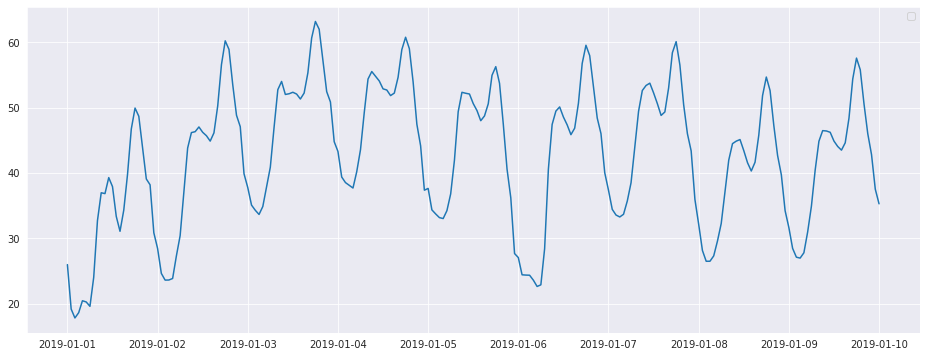

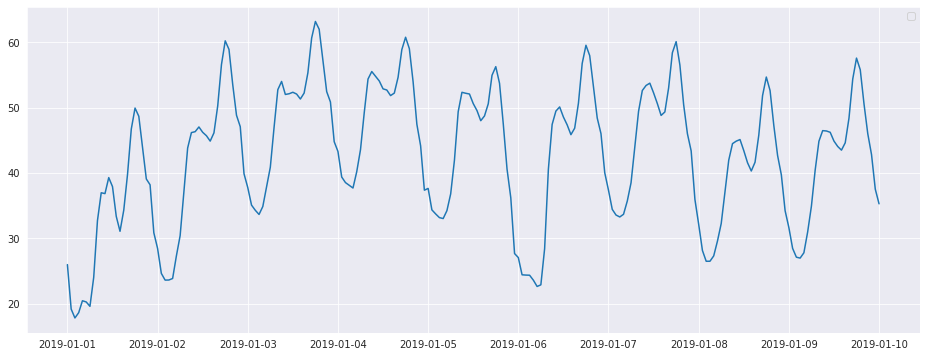

In [18]:
sns.set_style('darkgrid')
sns.mpl.rc('figure', figsize=(16,6))
AR_res.plot_predict(dt.datetime(2019,1,1), dt.datetime(2019,1,10), dynamic=True)

**Cross-validation**

In [0]:
prediction_window = 1
predict_from = test_df.index.min()
predict_until = predict_from + dt.timedelta(days=prediction_window)
predicted_series = AR_res.predict(start=predict_from, end=predict_until)

In [39]:
error_analysis(test_df['Day Ahead Price'], predicted_series)

{Timestamp('2019-08-05 19:00:00', freq='H'), Timestamp('2019-08-05 18:00:00', freq='H'), Timestamp('2019-08-05 17:00:00', freq='H'), Timestamp('2019-08-05 12:00:00', freq='H'), Timestamp('2019-08-06 05:00:00', freq='H'), Timestamp('2019-08-06 07:00:00', freq='H'), Timestamp('2019-08-05 08:00:00', freq='H'), Timestamp('2019-08-05 22:00:00', freq='H'), Timestamp('2019-08-06 03:00:00', freq='H'), Timestamp('2019-08-05 23:00:00', freq='H'), Timestamp('2019-08-05 20:00:00', freq='H'), Timestamp('2019-08-06 04:00:00', freq='H'), Timestamp('2019-08-05 16:00:00', freq='H'), Timestamp('2019-08-06 02:00:00', freq='H'), Timestamp('2019-08-05 14:00:00', freq='H'), Timestamp('2019-08-05 15:00:00', freq='H'), Timestamp('2019-08-05 09:00:00', freq='H'), Timestamp('2019-08-06 00:00:00', freq='H'), Timestamp('2019-08-05 13:00:00', freq='H'), Timestamp('2019-08-05 11:00:00', freq='H'), Timestamp('2019-08-06 06:00:00', freq='H'), Timestamp('2019-08-05 07:00:00', freq='H'), Timestamp('2019-08-05 10:00:00'

## Multivariate: VAR(k) and VECM

Instead of treating our series as a univariate time series for each hour, one can expect an improvement by considering it proper as a multivariate time series analysis. The relevant algorithms are the vector autoregressive model (VAR) and the vector error correction model (VECM).

In [0]:
from statsmodels.tsa.api import VAR

# 0.9/0.1-train/val split
train_df, val_df = test_train_timesplit(multi_df)

VAR_model = VAR(train_df, freq='D')
VAR_res = VAR_model.fit()

In [36]:
get_windowed_dataset(multi_df, ['Day Ahead Price'], ['Day Ahead Price'], 7)

([array([[[ 2.4970e+01,  2.4650e+01,  2.4680e+01, ...,  2.7420e+01,
            2.7020e+01,  2.2110e+01],
          [ 2.1920e+01,  1.9350e+01,  1.6110e+01, ...,  2.8620e+01,
            2.6710e+01,  1.5930e+01],
          [ 1.1550e+01,  1.3470e+01,  1.1230e+01, ...,  2.6690e+01,
            2.1640e+01,  1.4720e+01],
          ...,
          [ 5.0000e-02, -2.0600e+00, -4.1100e+00, ...,  9.2900e+00,
            1.0180e+01, -2.0000e+00],
          [ 9.3000e+00,  2.8700e+00,  9.0000e-02, ...,  1.5550e+01,
            1.4910e+01,  9.1000e+00],
          [ 9.2700e+00,  1.0420e+01,  1.1160e+01, ...,  2.9910e+01,
            2.7020e+01,  1.8360e+01]],
  
         [[ 2.1920e+01,  1.9350e+01,  1.6110e+01, ...,  2.8620e+01,
            2.6710e+01,  1.5930e+01],
          [ 1.1550e+01,  1.3470e+01,  1.1230e+01, ...,  2.6690e+01,
            2.1640e+01,  1.4720e+01],
          [ 1.7100e+01,  1.2930e+01,  1.3700e+01, ...,  1.1510e+01,
            1.1810e+01,  5.0800e+00],
          ...,
          [ 

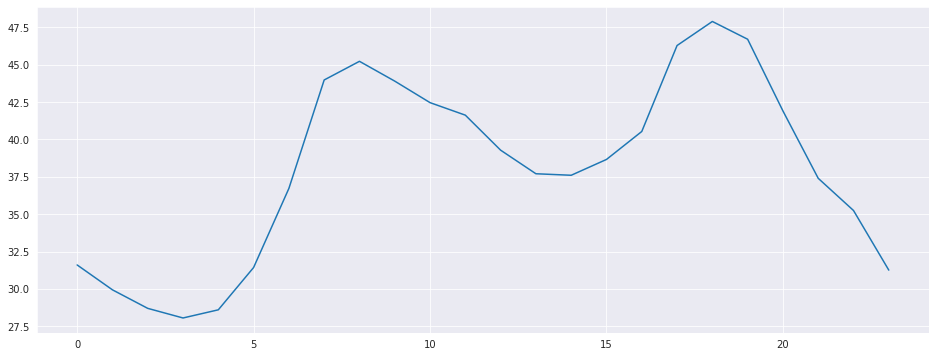

In [129]:
plt.plot(VAR_res.forecast(multi_df.tail(7).to_numpy(), 10)[0,:])

# Exponential Smoothing and Holtz-Winter models

Another popular approach to time-series problems are the ETS class of techniques. The ETS class of techniques derive inspiration from the mean average model, and instead take a weighted average of previous values along with the error in the forecast. In effect, it models the actual value dragging the prediction as it differs from the forecast.  
$$y_{t+h} = l_t +h b_t + s_{t+h-m(k+1)}$$
$$l_t = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(l_{t-1} + b_{t-1})$$
$$b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*)b_{t-1}$$
$$s_t = \gamma \frac{y_t}{(l_{t-1} + b_{t-1})} + (1-\gamma)s_{t-m}$$
The simplest version is the simple exponential smoothing model (with $\beta = 0, \gamma =0$):
$$y_{t+h} = y_{t} + \alpha (y_{t} - \hat{y}_{t})$$

In [0]:
from statsmodels.tsa.api import SimpleExpSmoothing

ets_model1 = SimpleExpSmoothing(df['Day Ahead Price'])
res = ets_model1.fit()

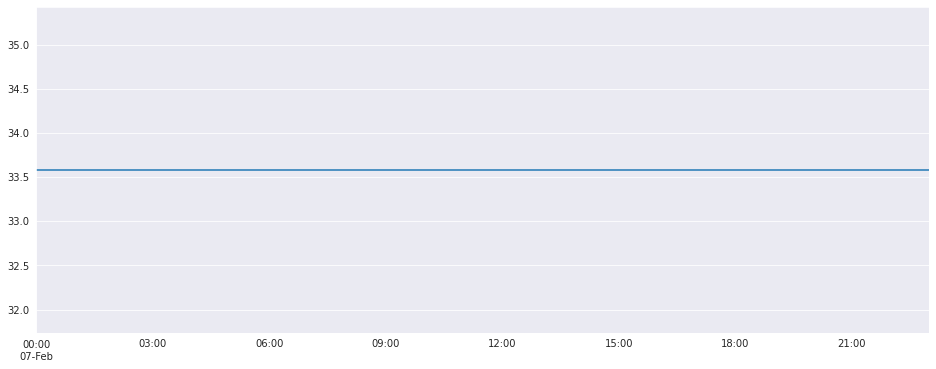

In [50]:
res.forecast(24).plot()

Try the multivariate version here instead.

**ETS with trend and seasonality: Holtz-Winter model**. 

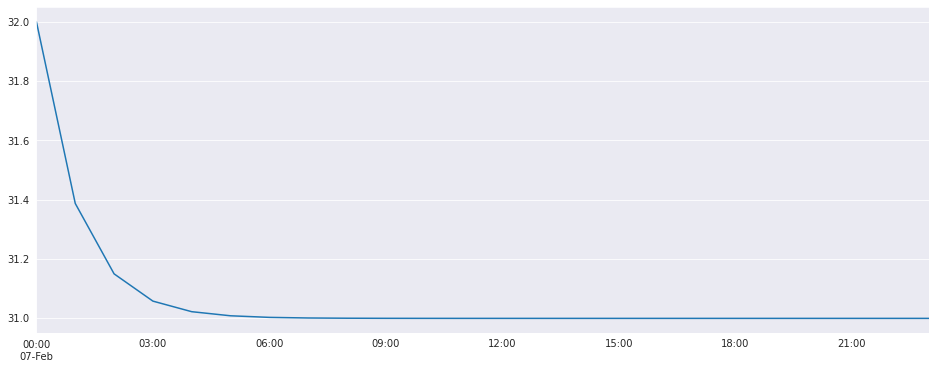

In [51]:
from statsmodels.tsa.api import Holt

ets_model3 = Holt(df['Day Ahead Price'], damped=True)
res = ets_model3.fit()
res.forecast(24).plot()

# Markov switching regression

# Bibliography

**[HA18]** R. J. Hyndman, and G. Athanasopoulos, Forecasting: Principles and Practice, https://otexts.com/fpp2/index.html 

**[HWL15]**. R. J. Hyndman, E. Wang, N. Laptev, *Large-Scale Unusual Time Series Detection*,  [https://robjhyndman.com/papers/icdm2015.pdf]

**[SE11]** More on the different approaches to the validation strategies for a time series here: https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

**[Tas00]** L. J. Tashman, *Out-of-sample tests of forecasting accuracy: an analysis and review*, International Journal of Forecasting, 2000, vol. 16, issue 4, 437-450 [https://econpapers.repec.org/article/eeeintfor/v_3a16_3ay_3a2000_3ai_3a4_3ap_3a437-450.htm].

Supplements:  
[Using Facebook's forecast engine: Prophet]()  
[GluonTS]()

Next part: [Deep Models]()